In [2]:
from cmath import cos
from inspect import _void
import math
from sys import flags
import networkx as nx
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy import signal, stats
import scipy.signal as spsg
from scipy.io import loadmat
import os
from sklearn.cluster import KMeans
import scipy
from scipy.spatial import distance
import time
import pandas as pd
import plotnine
import seaborn as sns
from statannot import add_stat_annotation
import ptitprince as pt

In [3]:
# Load data
# Data is a fake, import your own data instead
ts = np.load("Example Z-scored BOLD.npy")

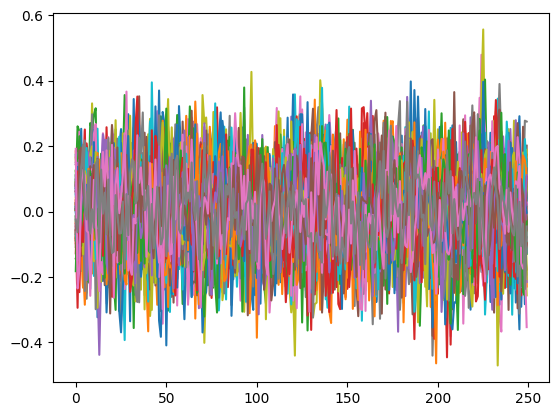

In [4]:
# Vizualize data
plt.plot(ts.T)

In [5]:
len(ts)

68

In [6]:
#Total_subj = len(ts) // Not needed since data is a single fake
ROI = len(ts)
Time_per_rec = len(ts[0])
#Time_per_cond = Total_subj*Time_per_rec // Same, only one 'subject' and one condition

In [7]:
# Z-score
# Already preprocessed so no need for these
#ts_all_zscored=np.array(stats.zscore(ts,axis=1))

# Detrend signal
#ts_all_zscored = spsg.detrend(ts_all_zscored,type='linear', axis=1)

# Demeaning signal
#ts_all_zscored = ts_all_zscored-np.mean(ts_all_zscored,axis=1)
signal = np.array(ts)

In [41]:
signal.shape

(68, 250)

In [8]:
# Analytical continuation of our signal
analytic_signal = spsg.hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

# To ensure that we can reconstruct our initial signal from the hilbert transform
signal_reconstr = amplitude_envelope*np.cos(instantaneous_phase) 
print(np.isclose(signal, signal_reconstr).all())

True


In [9]:
# Angular difference function useful just after
def adif(a, b):
    return 2*math.pi-abs(a-b) if abs(a-b)>math.pi else abs(a-b)

In [10]:
# Now we can calculate the phase difference between each pair of regions using the adif function
# We will store the phase differences in a matrix of size (n_regions, n_regions, n_timepoints)
phase_diff = np.zeros((ROI,ROI,Time_per_rec))

for t in range(Time_per_rec):
    temp = np.array(())
    for i in range(ROI):
        for j in range(ROI):
            if i==j:
                phase_diff[i,j,t] = 0
            else:
                phase_diff[i,j,t] = np.cos(adif(instantaneous_phase[i][t], instantaneous_phase[j][t]))
# Quite lengthy operation: hate those for loops :'(
# Find a way through numpy array handling

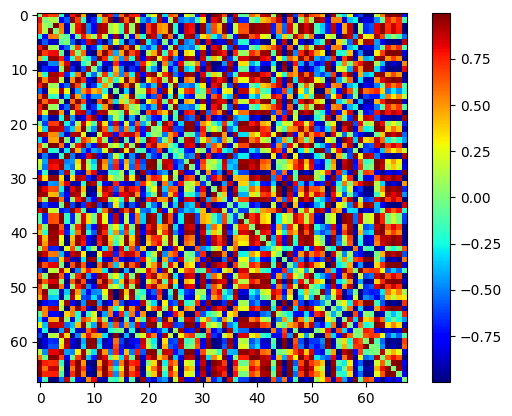

In [11]:
# Example of pattern of phase coherence between all regions at a given timepoint (t=10)
plt.imshow(phase_diff[:,:,10], cmap='jet')
plt.colorbar()

In [12]:
# To modify based on your dataset
# Assuming all the recordings are of the same temporal length
# Total_time = Time_per_recording * Total_subject
Total_time = len(instantaneous_phase[0])
size = int(ROI*(ROI-1)/2)
# Extract the superior triangular since the phase coherence matrix is symmetric
vectorized = np.zeros((Total_time,size))
for t in range(len(instantaneous_phase[0])):
    temp = np.array(())
    for j in range(len(instantaneous_phase)):
        for i in range(len(instantaneous_phase)):
            if i>j:
                temp = np.append(temp,phase_diff[i,j,t])
    vectorized[t,:] = temp

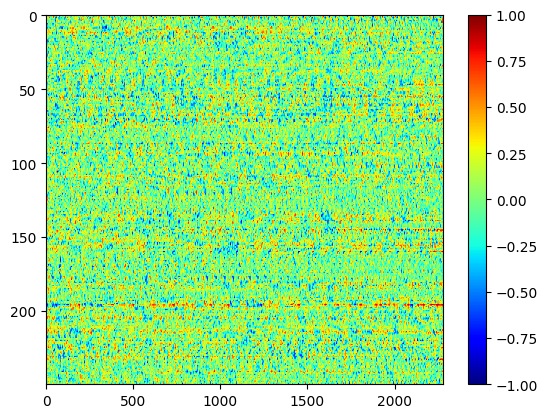

In [13]:
# Plot vectorized phase difference for all times
plt.figure()
plt.grid(False)
plt.imshow(vectorized, aspect='auto', cmap='jet')
plt.colorbar()
plt.show()

In [14]:
# K-Means
                                          
labels = ()
centroids = ()

for k in range(3, 11):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=200,init='k-means++').fit(vectorized)
    # 3 first elements are associated with the KMeans trained with k=3, the 4 to 7 are for k=4 and so on
    labels = np.append(labels, kmeans.labels_)
    centroids = np.append(centroids, kmeans.cluster_centers_)
#np.save('centroids k=3_10' , centroids)    
#np.save('labels k=3_10', labels)

In [15]:
ROI = 68
squareforms = np.empty((52,ROI,ROI))
for i in range(52):
    squareforms[i] = distance.squareform(centroids[i*size:(i+1)*size], force='tomatrix')

In [16]:
# Initialize variables
start_index = 0
groups = []

# Loop through each group
for group_size in range(3, 11):
    # Get the group and add it to the list of groups
    group = squareforms[start_index:start_index+group_size]
    groups.append(group)
    # Update the start index for the next group
    start_index += group_size

# Print the shape of each group
for i, group in enumerate(groups):
    print(f"Group {i+1}: {group.shape}")

squareforms = groups

Group 1: (3, 68, 68)
Group 2: (4, 68, 68)
Group 3: (5, 68, 68)
Group 4: (6, 68, 68)
Group 5: (7, 68, 68)
Group 6: (8, 68, 68)
Group 7: (9, 68, 68)
Group 8: (10, 68, 68)


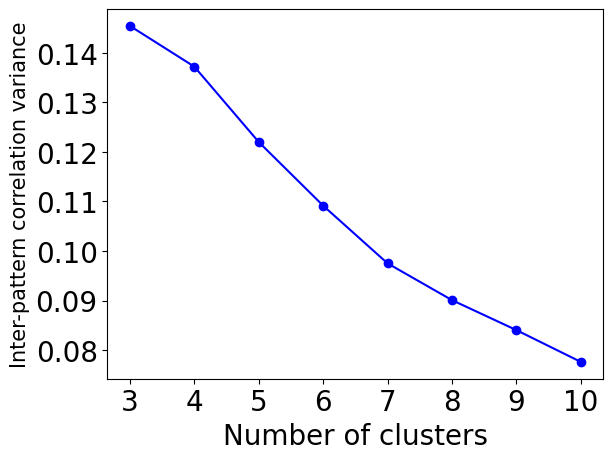

In [17]:
def inter_pattern_corr_var(sqf):
    
    k = len(sqf)
    
    correl = np.empty((k,k))

    for i in range(k):
        for j in range(k):
            correl[i,j] = np.corrcoef(sqf[i].flatten(),sqf[j].flatten())[0,1]
    
    return correl.var()

plop = []

for i in range(8):
    plop = np.append(plop,inter_pattern_corr_var(squareforms[i]))
    
plt.plot(plop, 'o-b')
plt.ylabel('Inter-pattern correlation variance', fontsize=15)
plt.xlabel('Number of clusters', fontsize=20)
plt.xticks(ticks=np.arange(8),labels=np.arange(3,11,1),fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('Inter-pattern correlation variance.png')
plt.show()

In [18]:
# Individualize the results for each k
labels_k3 = labels[0:Total_time]
labels_k4 = labels[Total_time:2*Total_time]
labels_k5 = labels[2*Total_time:3*Total_time]
labels_k6 = labels[3*Total_time:4*Total_time]
labels_k7 = labels[4*Total_time:5*Total_time]
labels_k8 = labels[5*Total_time:6*Total_time]
labels_k9 = labels[6*Total_time:7*Total_time]
labels_k10 = labels[7*Total_time:8*Total_time]
centroids_k3 = squareforms[0]
centroids_k4 = squareforms[1]
centroids_k5 = squareforms[2]
centroids_k6 = squareforms[3]
centroids_k7 = squareforms[4]
centroids_k8 = squareforms[5]
centroids_k9 = squareforms[6]
centroids_k10 = squareforms[7]

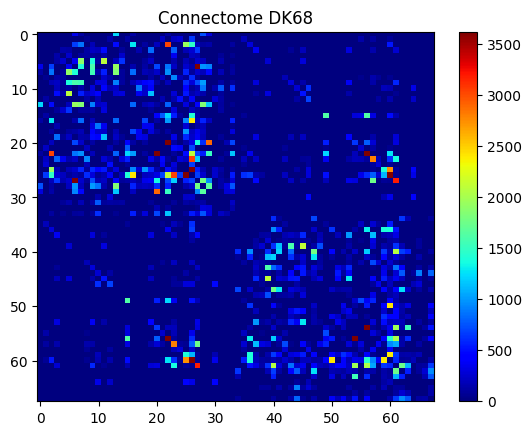

In [19]:
# Import the atlas
Connectome = loadmat("DTI_fiber_consensus_HCP.mat")['connectivity']
VConnectome = Connectome.flatten()

# Plot it
plt.figure()
plt.grid(False)
plt.imshow(Connectome, aspect='auto', cmap='jet')
plt.colorbar()
plt.title("Connectome DK68")
#plt.savefig("Connectome DK68")
plt.show()

In [20]:
np.info(Connectome)

class:  ndarray
shape:  (68, 68)
strides:  (8, 544)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x148270020
byteorder:  little
byteswap:  False
type: float64


In [21]:
def get_sorted_corr(squareform,k):
    # Compute Anatomo-Functional correlation 
    Corr_AF = np.zeros((k,1))
    for i in range(k):
        Corr_AF[i] = np.corrcoef(VConnectome,squareform[i].flatten())[1][0]
    sorted_corr = np.sort(Corr_AF, axis=None)
    return sorted_corr, Corr_AF

In [22]:
def sorted_corr_with_connectome(squareform, Predict,k):
    '''
    Return the centroids sorted by increasing correlation with the connectome
    And the chain of states with the new associated integer labels
    ''' 

    # Compute Anatomo-Functional correlation 
    Corr_AF = np.zeros((k,1))
    for i in range(k):
        Corr_AF[i] = np.corrcoef(VConnectome,squareform[i].flatten())[1][0]
    sorted_corr = np.sort(Corr_AF, axis=None)
    
    # Find permutations to sort clusters 
    permutation = np.zeros((k,1))
    permutation_ = np.zeros((k,1))
    for i in range(k):
        permutation[i] = np.where(sorted_corr[i]==Corr_AF)[0][0]
        permutation_[i] = np.where(Corr_AF[i]==sorted_corr)[0][0]
        
    # Apply permutations
    new_squareforms = np.empty_like(squareform)
    for i in range(k):
        new_squareforms[i] = squareform[int(permutation[i])]
    squareform = new_squareforms

    new_labels = np.empty_like(Predict)
    for i in range(len(Predict)):
        new_labels[i] = permutation_[int(Predict[i])]
    Predict = new_labels+1
    return squareform,Predict.astype(int)

In [23]:
# Careful not to run this cell more than once!
# Otherwise directly extract the centroids from squareforms[k-3] and labels[Total_time*(k-3):Total_time*(k-2)]
centroids_k3, labels_k3 = sorted_corr_with_connectome(centroids_k3,labels_k3,3)
centroids_k4, labels_k4 = sorted_corr_with_connectome(centroids_k4,labels_k4,4)
centroids_k5, labels_k5 = sorted_corr_with_connectome(centroids_k5,labels_k5,5)
centroids_k6, labels_k6 = sorted_corr_with_connectome(centroids_k6,labels_k6,6)
centroids_k7, labels_k7 = sorted_corr_with_connectome(centroids_k7,labels_k7,7)
centroids_k8, labels_k8 = sorted_corr_with_connectome(centroids_k8,labels_k8,8)
centroids_k9, labels_k9 = sorted_corr_with_connectome(centroids_k9,labels_k9,9)
centroids_k10, labels_k10 = sorted_corr_with_connectome(centroids_k10,labels_k10,10)

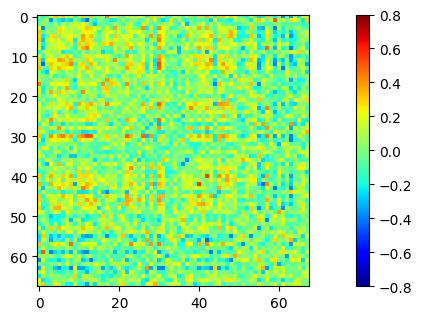

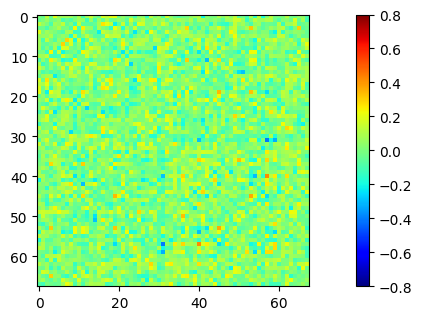

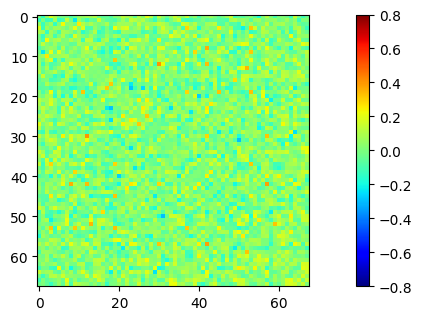

In [24]:
def plot_centroids(ct,k):
    for i in range(k):
        plt.figure()
        plt.subplot(k,1,i+1)
        plt.gcf().set_size_inches(12,12)
        plt.imshow(ct[i], cmap='jet',vmin=-0.8,vmax=0.8)
        plt.colorbar()
        plt.show()

plot_centroids(centroids_k3,3)

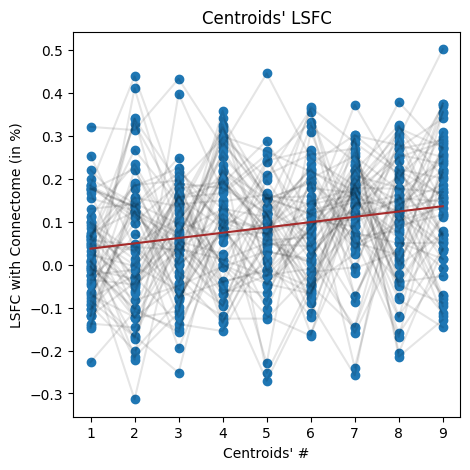

In [25]:
def get_normalized_counts(labels,k):
    counts = np.zeros(k)
    for j in range(k):
        counts[j] = sum(labels==j+1)/len(labels)
    return counts

def get_std(lb,k):
    probability_values = get_normalized_counts(lb,k)
    standard_deviation = np.std(probability_values, ddof=1)
    standard_error = standard_deviation / np.sqrt(len(probability_values))
    
    return standard_error

def get_sorted_corr(squareform, Predict,k):
    # Compute Anatomo-Functional correlation 
    Corr_AF = np.zeros((k))
    for i in range(k):
        Corr_AF[i] = np.corrcoef(VConnectome,squareform[i].flatten())[1][0]
    sorted_corr = np.sort(Corr_AF, axis=None)
    return sorted_corr

def lsfc(centroids):
    k = centroids.shape[0]
    ROI = centroids.shape[1]
    SFC = np.empty((ROI,k))
    for j in range(k):
        for i in range(ROI):
            SFC[i,j] = np.corrcoef(centroids[j,i,:],Connectome[i,:])[0,1]

    fig, ax= plt.subplots(figsize = (5,5))



    x = np.empty((k,ROI))
    y = np.empty((k,ROI))
    for i in range(k):
        x[i] = (int(i)+1)*np.ones(ROI)
        y[i] = SFC[:,i]

    ax.scatter(x,y)
    plt.plot(x,y,c='black',alpha=0.1)

    x=np.arange(1,k+1).reshape(-1, 1)
    y=[np.mean(SFC[:,i]) for i in range(k)]

    reg = LinearRegression().fit(x,y)
    a = reg.coef_
    b = reg.intercept_
    Y = a * x + b

    ax.plot(x,Y,c='brown')
    ax.annotate("Slope = "+str(round(a[0],3)),xy=(4.2,0.7),color='black',size=14, c='brown')
    plt.xlabel("Centroids' #")
    plt.ylabel("LSFC with Connectome (in %)")
    plt.title("Centroids' LSFC")
    #plt.savefig("Centroids LSFC")
    plt.show()

lsfc(centroids_k9)

In [26]:
def boxplot_histogram(sorted_labels,conditions,k):
    for i in range(len(conditions)):
        plt.figure()
        plt.grid(None)

        if k==3:
            plt.xlabel("Centroid #", fontsize=40)
            plt.ylabel("Proportion (%)",fontsize=40)
        _ = np.arange(1,k+1,1)

        counts = get_normalized_counts(sorted_labels[i*Time_per_cond:(i+1)*Time_per_cond],k)
        print(counts)

        plt.bar(np.arange(1,k+1,1),counts,color=colors[i],yerr=get_std(sorted_labels[i*Time_per_cond:(i+1)*Time_per_cond],k),capsize=10)
        plt.ylim((0,0.8))
        plt.xticks(np.arange(1,k+1,1),fontsize=30)
        plt.yticks(fontsize=30)
        #plt.savefig(title+' (ADR68)')
        plt.show()
        print(counts)

In [27]:
# Experimental parameters
# Adjust them to your dataset

colors = ['blue'] # As many colors as conditions

conditions = ['test']

Time_per_rec = 250 # Assuming all conditions' recordings are of the same temporal length

num_subj = 1
num_subj_per_cond = 1
num_cond = len(conditions)

Time_per_cond = 250 # Assuming all subjects have the same temporal length, = Time_per_rec * num_subj_per_cond

#Adjust based on what conditions you would like to perform statistical tests about
#pairs_conditions = [(("Awake"), ("G.A.")),(("Awake"), ("Recovery")),(("G.A."), ("Recovery"))]


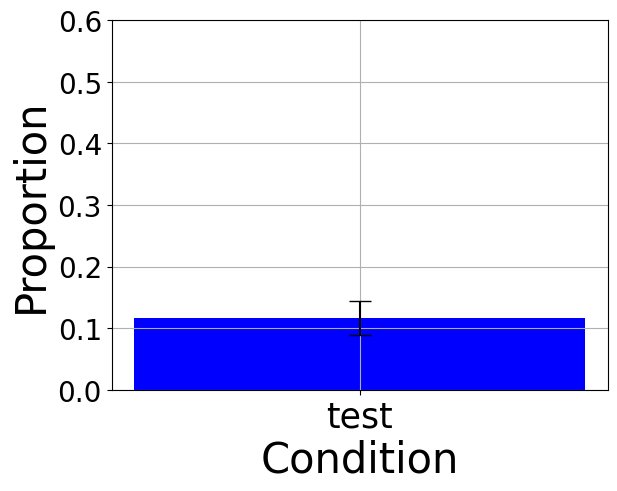

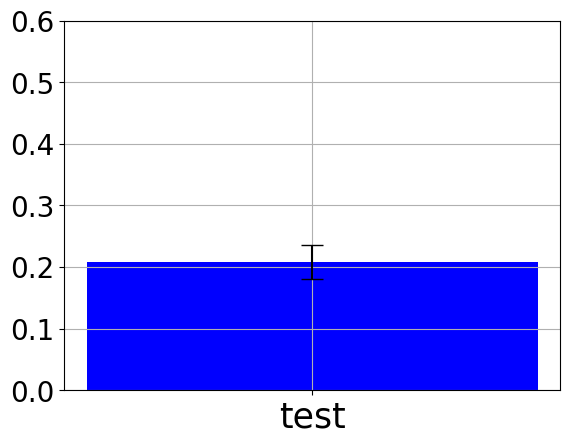

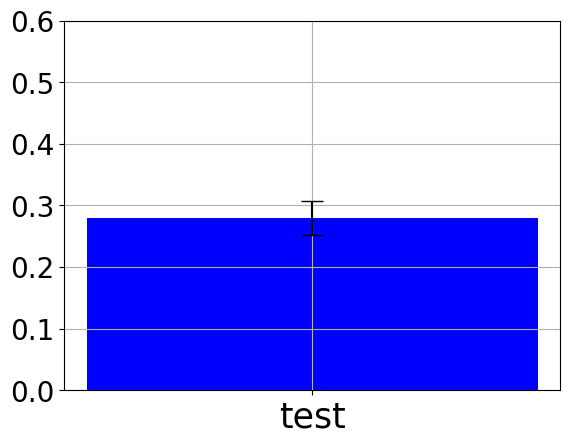

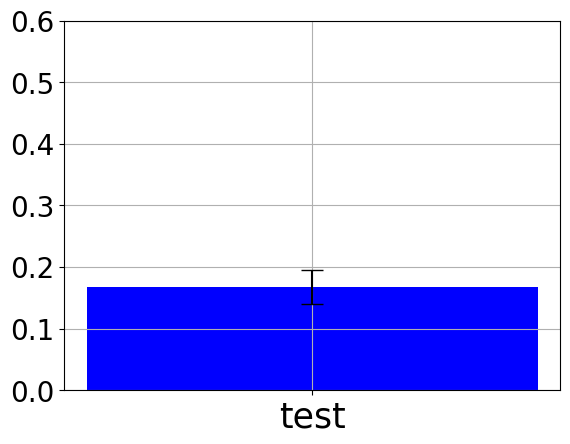

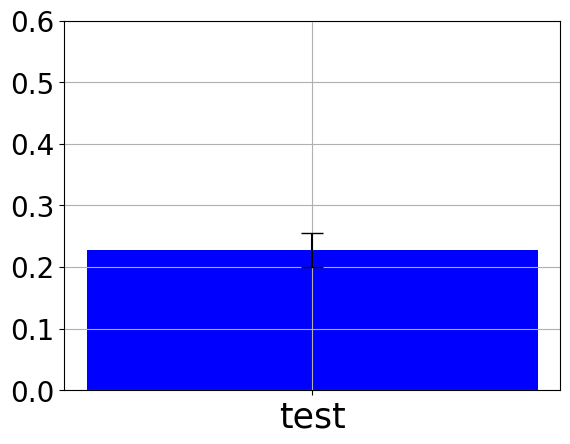

array([0.228])

In [28]:
def barplot_centroids(labels,k):
    a = np.zeros(num_cond)
    for kk in range(k):
        for i in range(num_cond):
            labels_ = labels[i*Time_per_cond:(i+1)*Time_per_cond]
            a[i] = np.count_nonzero(labels_==kk+1)/Time_per_cond

        plt.bar(np.arange(1,num_cond+1,1),a,color=colors,label=conditions,yerr=get_std(labels,k),capsize=8)
        plt.ylim((0,0.6))
        if kk == 0:
            plt.xticks(np.arange(1,num_cond+1,1), conditions,fontsize=25)
            plt.yticks(fontsize=20)
            plt.ylabel('Proportion',fontsize=30)
            plt.xlabel('Condition',fontsize=30)
        else:
            plt.xticks(np.arange(1,num_cond+1,1), conditions,fontsize=25)
            plt.yticks(fontsize=20)
        #plt.savefig(title+' (ADR68)')
        plt.grid(None)
        plt.show()
        plt.close()
    return a

barplot_centroids(labels_k5,5)

[0.168 0.376 0.456]


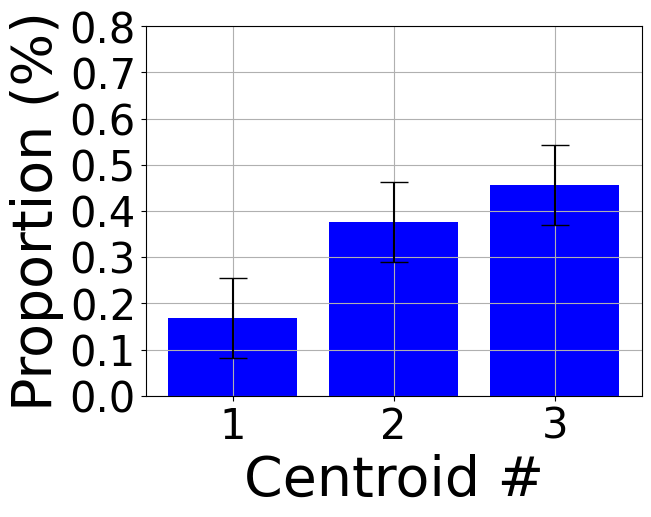

[0.168 0.376 0.456]
[0.236 0.26  0.32  0.184]


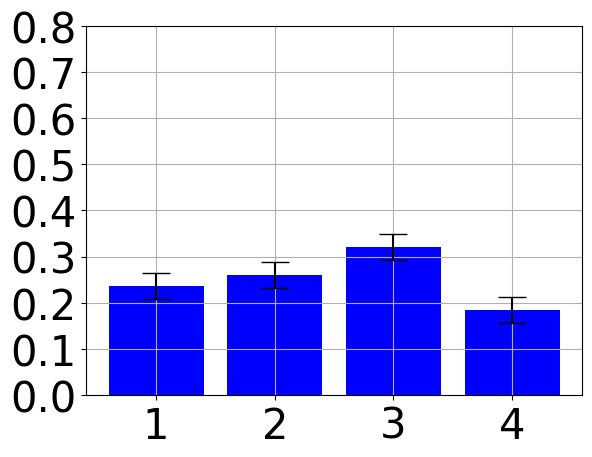

[0.236 0.26  0.32  0.184]
[0.116 0.208 0.28  0.168 0.228]


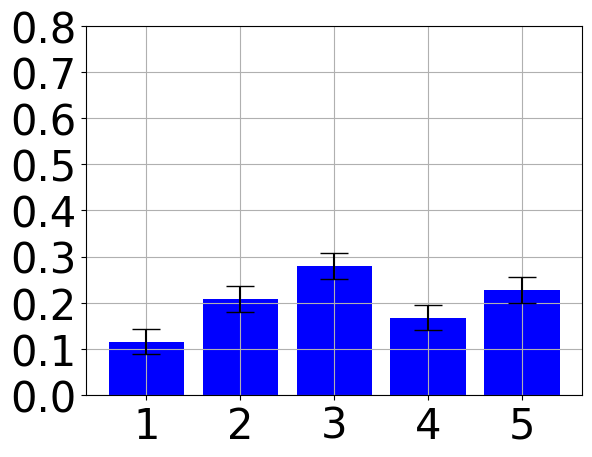

[0.116 0.208 0.28  0.168 0.228]
[0.164 0.164 0.204 0.144 0.164 0.16 ]


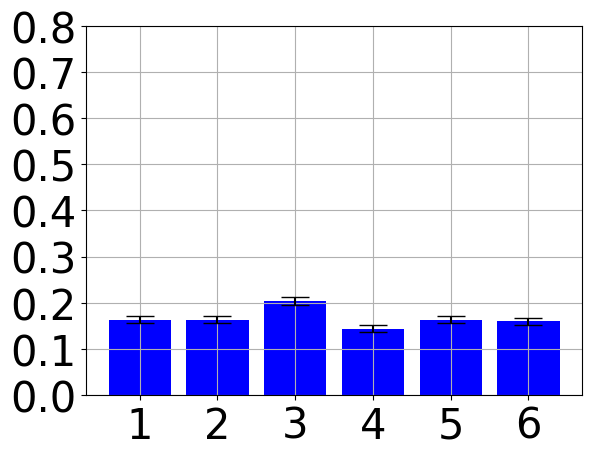

[0.164 0.164 0.204 0.144 0.164 0.16 ]
[0.2   0.12  0.136 0.132 0.128 0.124 0.16 ]


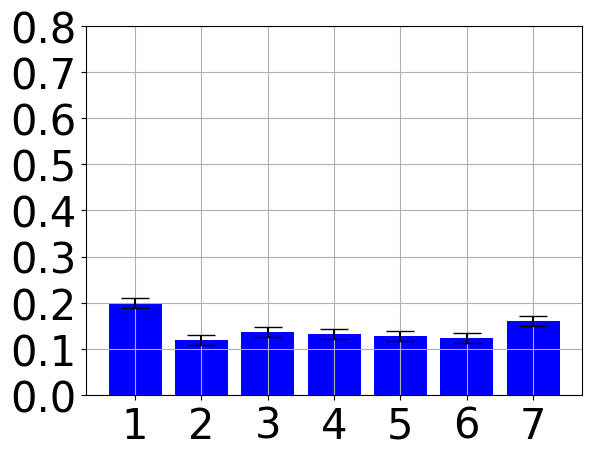

[0.2   0.12  0.136 0.132 0.128 0.124 0.16 ]
[0.04  0.124 0.1   0.132 0.108 0.164 0.148 0.184]


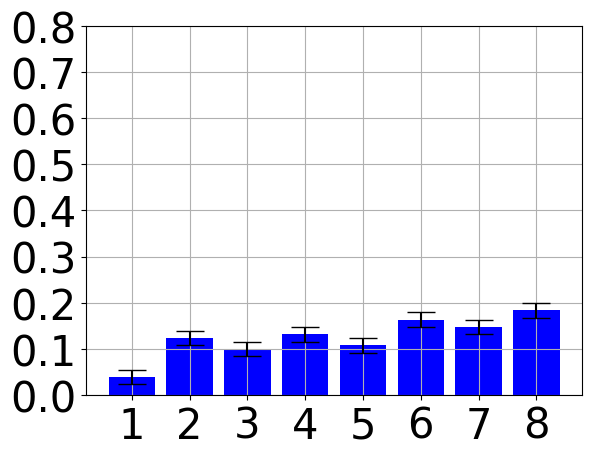

[0.04  0.124 0.1   0.132 0.108 0.164 0.148 0.184]


In [29]:
boxplot_histogram(labels_k3,conditions,3)
boxplot_histogram(labels_k4,conditions,4)
boxplot_histogram(labels_k5,conditions,5)
boxplot_histogram(labels_k6,conditions,6)
boxplot_histogram(labels_k7,conditions,7)
boxplot_histogram(labels_k8,conditions,8)

In [30]:
def plot_slop(all_cond_sorted_labels,condition):
    #savefig_bool = bool(input("Should the incomming plot be saved (True or False)"))
    #k = int(input("How many clusters are there?"))
    Time_per_cond = int(len(all_cond_sorted_labels)/len(condition))
    for cond in range(len(condition)):
        labels_cond = all_cond_sorted_labels[cond*Time_per_cond:(cond+1)*Time_per_cond]
        g = np.empty((num_subj_per_cond,k))
        for i in range(len(g)):
            counts=np.empty(k)
            inv = np.empty(k)
            inv_ = np.empty_like(inv)
            _, inv = np.unique(labels_cond[i*Time_per_rec:(i+1)*Time_per_rec], return_counts=True)
            if len(_) != k:
                for l in range(len(_)):
                    for j in range(k):
                        if j==_[l]:
                            inv_[j]=inv[l]
                g[i] = inv_
            else:
                g[i] = inv
            g[i] /= np.sum(g[i])
        g_ = np.mean(g,axis=0)
        A = get_sorted_corr()
        x = []
        for i in range(len(g)):
            x = np.append(x,A)
        x = x.reshape((-1,1))
        x_ = A

        y = g.reshape(-1,1)

        # fit a linear curve and estimate its y-values and their error.
        a, b, r_value, p_value, std_err = scipy.stats.linregress(x_, g_)

        # Build a rectangle in axes coords
        left, width = .35, .5
        bottom, height = 0, .5
        right = left + width
        top = bottom + height


        y_est = a * x_ + b
        y_err = x_.std() * np.sqrt(1/len(x_) +
                                  (x_ - x_.mean())**2 / np.sum((x_ - x_.mean())**2))
    fig, ax = plt.subplots()
    ax.plot(x_, y_est, '-')
    ax.text(right, top, 'Slope = '+str(round(a,3)),
    horizontalalignment='right',
    verticalalignment='top',
    transform=ax.transAxes, color='royalblue')
    plt.ylabel("Rate")
    plt.title("Centroids' rate of presence in "+str(condition[cond])+" condition as function of their SFC")
    plt.xlabel("SFC")
    #plt.ylim((-0.05,0.6))
    ax.plot(x, y, 'o', color='tab:brown')
        #if savefig_bool:
        #   plt.savefig("Rate of Centroids as function of SFC - "+str(condition[cond])+" (ADR68)")

In [31]:
from statsmodels.stats.anova import AnovaRM

def distribution_pattern_occupation(labels, k, condition,plot):
    u = np.arange(1,k+1,1)
    counts = get_normalized_counts(labels,k)
    #plt.savefig("Pattern distribution k="+str(k)+"condition "+str(condition))
    if plot:
        error = get_std(labels,k)
        print("Error: ", counts)
        #plt.title('Distribution of Pattern Occupation for condition '+ str(condition)+' for k='+str(k))
        plt.xlabel("Centroids' tag number")
        plt.ylabel("Proportion")
        plt.bar(u, counts, yerr=error, ecolor='black', width=0.3,capsize=8)
        plt.xticks(np.arange(1,k+1,1))
        plt.ylim((0,1))
        plt.show()
        plt.close()
    return counts

def get_normalized_counts(labels,k):
    counts = np.zeros(k)
    for j in range(k):
        counts[j] = sum(labels==j+1)/len(labels)
    return counts

def get_std(lb,k):
    
    probability_values = get_normalized_counts(lb,k)
    # Compute the standard deviation
    standard_deviation = np.std(probability_values, ddof=1)

    # Compute the standard error
    standard_error = standard_deviation / np.sqrt(len(probability_values))
    return standard_error


def boxplot_slope(centroids,labels,k,pairs_conditions):
    '''
    Draws boxplot of the slope of each subject for each condition
    Requieres at least 2 conditions otherwise the figure is useless
    And same amount of subjects per condition
    Otherwise the dataframe needs to be created manually
    But the plotting will be performed, and the statistical test will result in a NaN p-value hence the error
    > tests (str) must be one of:
        - `Levene`
        - `Mann-Whitney`
        - `Mann-Whitney-gt`
        - `Mann-Whitney-ls`
        - `t-test_ind`
        - `t-test_welch`
        - `t-test_paired`
        - `Wilcoxon`
        - `Kruskal`
    '''
    
    conditions = np.unique(pairs_conditions)
    n_cond = len(conditions)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    A = get_sorted_corr(centroids,labels,k)

    boxplt = []
    x_ = A

    for i in range(num_subj):
        g_ = distribution_pattern_occupation(labels[Time_per_rec*i:Time_per_rec*(i+1)],k,1,False)
        # fit a linear curve and estimate its y-values and their error.
        a, b, r_value, p_value, std_err = scipy.stats.linregress(x_, g_)
        y_est = a * x_ + b
        y_err = x_.std() * np.sqrt(1/len(x_) +
                                        (x_ - x_.mean())**2 / np.sum((x_ - x_.mean())**2))
        boxplt = np.append(boxplt,a)

    lst = []
    for cond in range(n_cond):
        for _ in range(num_subj_per_cond):
            lst.append(conditions[cond])

    A = boxplt[0:num_subj_per_cond]
    for i in range(1,n_cond):
        A = np.concatenate([A,boxplt[i*num_subj_per_cond:(i+1)*num_subj_per_cond]]).reshape(-1)
    
    df = pd.DataFrame(data=np.array((A,lst), dtype=object).T, columns=['Slope','Condition'])
    x = df['Slope'].astype(str).astype(float)
    df['Slope'] = x

    sns.set(style="whitegrid")

    x = "Condition"
    y = "Slope"

    ax = sns.boxplot(data=df, x=x, y=y)
    #plt.ylabel("Slope coefficient", fontsize=24)
    #plt.xlabel("Condition", fontsize=24)
    for i in range(num_cond):
        plt.scatter(np.ones(num_subj_per_cond)*i,boxplt[i*num_subj_per_cond:(i+1)*num_subj_per_cond],color=colors[i])

    add_stat_annotation(ax, data=df, x=x, y=y,
                                box_pairs=pairs_conditions,
                                test='t-test_paired', text_format='full', loc='inside', verbose=1)
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

    patients_ids = np.tile(np.arange(1,num_subj_per_cond+1,1),n_cond)
    conditions_ids = np.repeat(np.arange(n_cond), num_subj_per_cond)

    df = pd.DataFrame({'patient': patients_ids.reshape(-1),
                   'condition': conditions_ids,
                   'slop': boxplt})
    
    results = AnovaRM(data=df, depvar='slop', subject='patient', within=['condition']).fit()
    pv = results.anova_table["Pr > F"][0]
    plt.ylim((-1,9))

    ax.annotate(f'AnovaRM: {pv:.3e}',
            xy=(.175, 1.15), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=25)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylabel("Slope coefficient", fontsize=40)
    plt.xlabel("Condition", fontsize=40)
    #ax.set_title("Slope's coefficient ADR68")
    plt.show()
    plt.close()

In [32]:
pairs_conditions = [(('Test'),('Test'))]

/Applications/MNE-Python/.mne-python/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: divide by zero encountered in true_divide
/Applications/MNE-Python/.mne-python/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test v.s. Test: t-test paired samples with Bonferroni correction, P_val=nan stat=nan


/Applications/MNE-Python/.mne-python/lib/python3.10/site-packages/statsmodels/stats/anova.py:591: RuntimeWarning: invalid value encountered in double_scalars
/Applications/MNE-Python/.mne-python/lib/python3.10/site-packages/statsmodels/stats/anova.py:594: RuntimeWarning: invalid value encountered in double_scalars


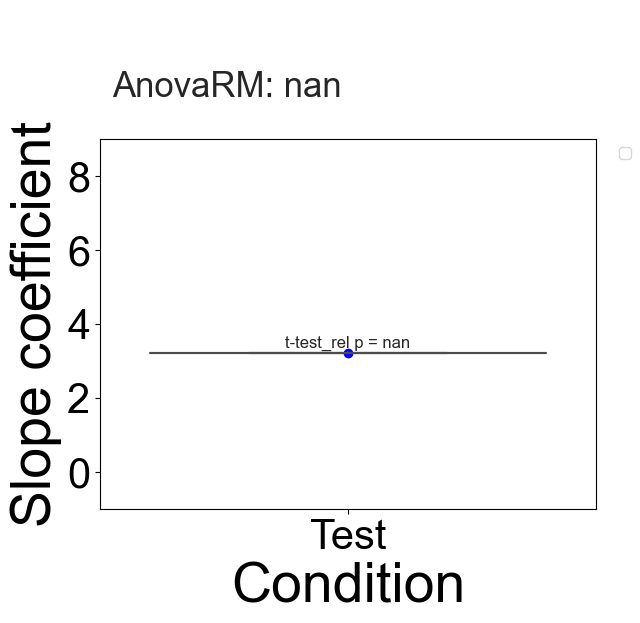

In [33]:
boxplot_slope(centroids_k3,labels_k3,3,pairs_conditions)

In [34]:
from matplotlib.ticker import FormatStrFormatter

# plot_slops_in_one outputs 1 plot with all the conditions
sign = ['o'] # Add as many signs as conditions based on matplotlib markers 

savefig_bool = False

def plot_slops_in_one(cts,all_cond_sorted_labels,condition,k,color):
    #savefig_bool = bool(input("Should the incomming plot be saved (True or False)"))
    #k = int(input("How many clusters are there?"))
    Time_per_cond = int(len(all_cond_sorted_labels)/len(condition))
    n_cond = len(condition)
    a_cond = np.empty(len(condition))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.grid(False)
    left, width = .35, .5
    bottom, height = 0, .5
    right = left + width
    top = bottom + height
    A = get_sorted_corr(cts,all_cond_sorted_labels,k)
    a_subj = np.empty((num_subj_per_cond,n_cond))

    for cond in range(len(condition)):
        labels_cond = all_cond_sorted_labels[cond*Time_per_cond:(cond+1)*Time_per_cond]
        g = np.empty((num_subj_per_cond,k))
        for i in range(len(g)):
            g[i]=distribution_pattern_occupation(labels_cond[i*Time_per_rec:(i+1)*Time_per_rec],k,['Awake','DPP', 'Recovery'],False)
            a_subj[i,cond] = scipy.stats.linregress(A, g[i]).slope
        g_ = np.mean(g,axis=0)
        x = []
        for i in range(len(g)):
            x = np.append(x,A)
        x = x.reshape((-1,1))
        x_ = A

        y = g.reshape(-1,1)
        # fit a linear curve and estimate its y-values and their error.
        a, b, r_value, p_value, std_err = scipy.stats.linregress(x_, g_)

        y_est = a * x_ + b
        y_err = x_.std() * np.sqrt(1/len(x_) +
                                  (x_ - x_.mean())**2 / np.sum((x_ - x_.mean())**2))
        ax.plot(x_, y_est, color=color[cond], linewidth=4)
        ax.plot(x, y, sign[cond], color=color[cond],mfc='none')
        plt.xlabel("SFC", fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel("Rate", fontsize=30)
        a_cond[cond] = a
    #plt.ylabel("Rate")
    #plt.xlabel("SFC")
    plt.ylim((-0.05,1.05))
    #plt.vlines(x=A, ymin=-0.1, ymax=0.9, colors='grey', ls=':', lw=2, label='vline_single - full height')
    plt.show()
    
    if savefig_bool:
       plt.savefig("Rate of Centroids as function of SFC - k="+str(k)+" (ADR68)",dpi=185,format='png')

    return a_cond,a_subj


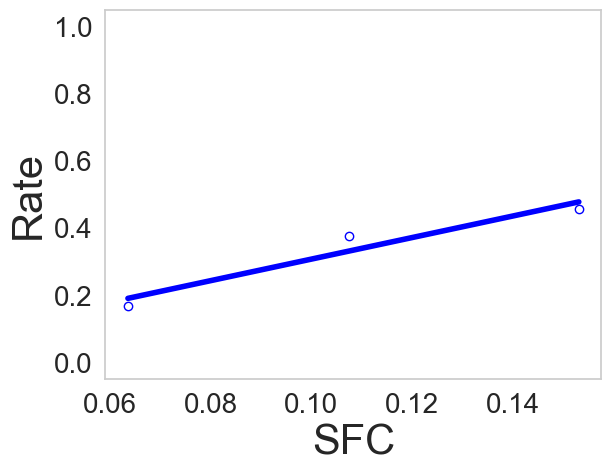

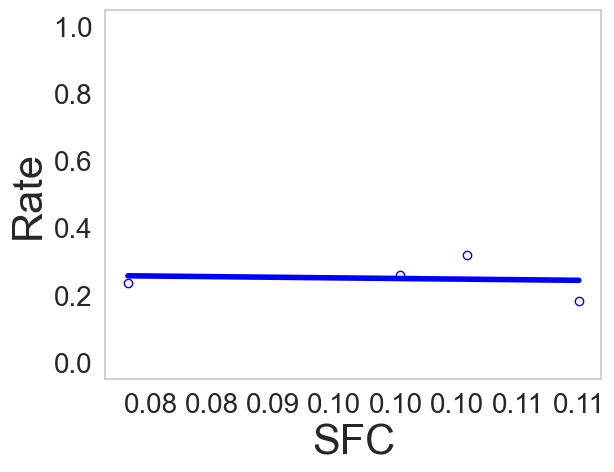

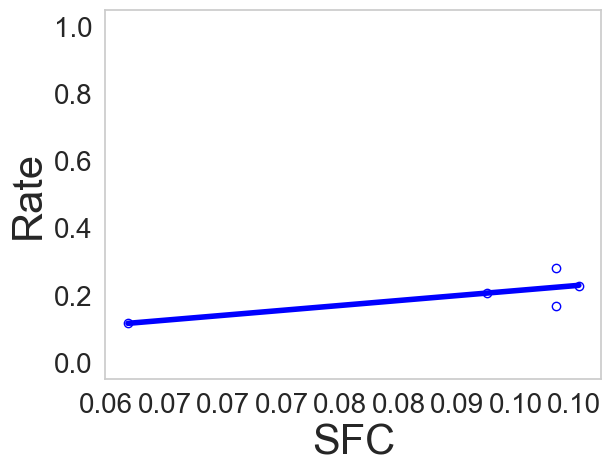

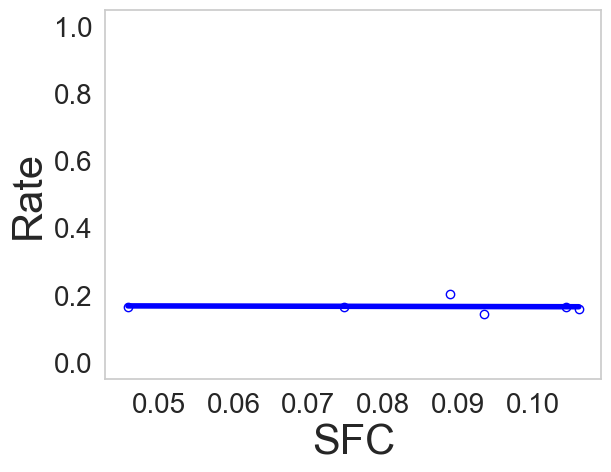

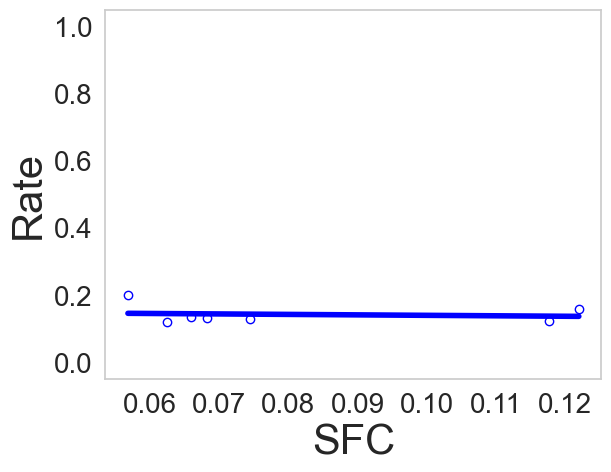

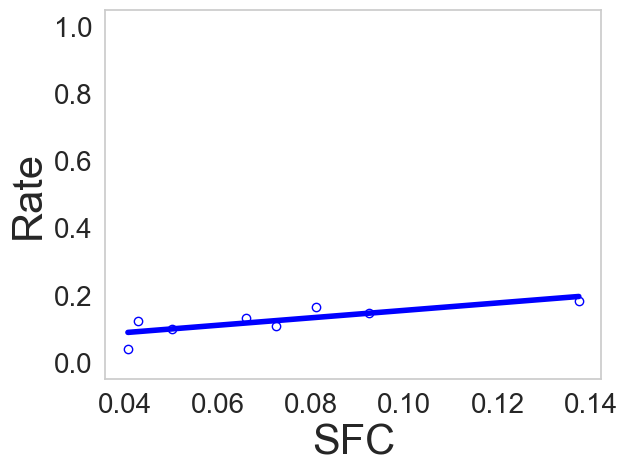

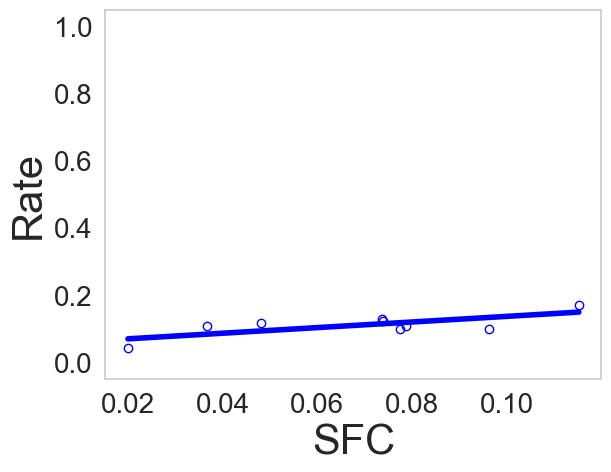

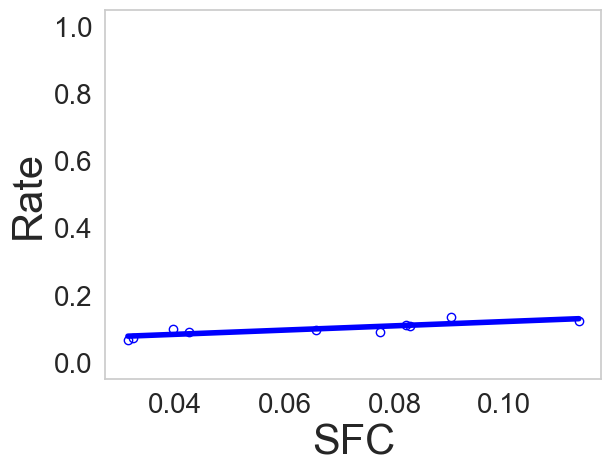

In [35]:
a_cond_k3, a_subj_k3 = plot_slops_in_one(centroids_k3,labels_k3,['Test'],3,colors)
a_cond_k4, a_subj_k4 = plot_slops_in_one(centroids_k4,labels_k4,['Test'],4,colors)
a_cond_k5, a_subj_k5 = plot_slops_in_one(centroids_k5,labels_k5,['Test'],5,colors)
a_cond_k6, a_subj_k6 = plot_slops_in_one(centroids_k6,labels_k6,['Test'],6,colors)
a_cond_k7, a_subj_k7 = plot_slops_in_one(centroids_k7,labels_k7,['Test'],7,colors)
a_cond_k8, a_subj_k8 = plot_slops_in_one(centroids_k8,labels_k8,['Test'],8,colors)
a_cond_k9, a_subj_k9 = plot_slops_in_one(centroids_k9,labels_k9,['Test'],9,colors)
a_cond_k10, a_subj_k10 = plot_slops_in_one(centroids_k10,labels_k10,['Test'],10,colors)

(-1.0, 7.5)

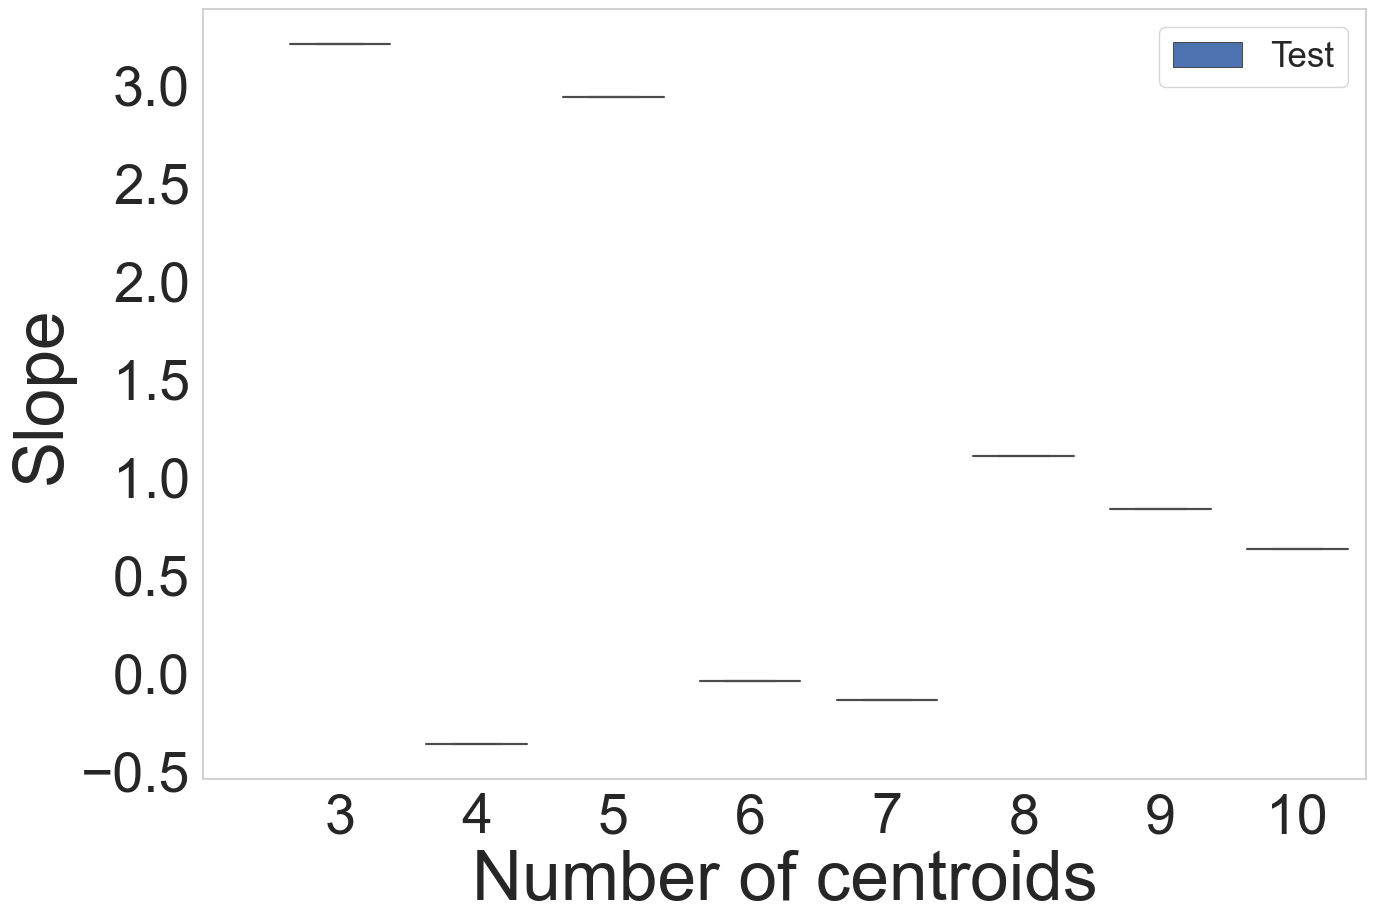

In [36]:
df = pd.DataFrame(columns=['k','condition','slope'])
df['k'] = np.array((np.repeat(3,num_subj),np.repeat(4,num_subj),np.repeat(5,num_subj),np.repeat(6,num_subj),np.repeat(7,num_subj),np.repeat(8,num_subj),np.repeat(9,num_subj),np.repeat(10,num_subj))).reshape(-1)

# The following two lines need to be personalized based on the number of conditions
# In the next cell will be the code we used for 3 conditions and 16 subjects per cond so one can more easily see what to change
df['condition'] = np.tile(np.array(np.repeat('Test',num_subj_per_cond)),8).reshape(-1)
df['slope'] = np.concatenate((a_subj_k3,a_subj_k4,a_subj_k5,a_subj_k6,a_subj_k7,a_subj_k8,a_subj_k9,a_subj_k10))

dx = "k"; dy = "slope"; ort = "v"; pal = sns.color_palette(); sigma = .21; dhue = "condition"
f, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(x = dx, y = dy, hue=dhue,data = df, color = "black", width = .75, showcaps = True,
    showfliers=True, saturation = 1, orient = ort,palette=sns.color_palette())

plt.xlabel('Number of centroids',fontsize=50)
plt.ylabel('Slope',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(False)
plt.legend(loc='upper right',fontsize=25)
ax.set_xlim(-1,7.5)
#ax.set_aspect(0.5)


In [51]:
from scipy.stats import ttest_ind
import seaborn as sns

def remove_redundancies(labels):
    '''
    Remove the redundancies in the chain of states
    Example: 1-1-1-2-1-1-3-3-3 becomes 1-2-1-3
    Used to compute the probability of each transition without self-transitions
    '''
    lb_ = []
    for i in range(len(labels)-1):
        if i % Time_per_rec == 0 and i!=0:
            continue
        if i+1 == len(labels)-1:
            lb_ = np.append(lb_,labels[i+1])
        elif labels[i] != labels[i+1]:
            lb_ = np.append(lb_,labels[i])
    return lb_

def probability_per_individu(labels,k,alternative_type):
    '''
    Compute the probability of each transition for each subject and the average lifetime of each state for each subject
    As well as the p-value of the statistical test for each transition and each average lifetime
    This implementation only covers 2 or 3 conditions. For more, an automatized version is recommended
    '''
    average_lifetime = np.zeros((num_subj_per_cond,num_cond,k))
    probabilities = np.zeros((num_subj_per_cond,num_cond,k,k))
    for condition in range(num_cond):
        for individu in range(num_subj_per_cond):
            subj_labels = labels[Time_per_rec*individu+(Time_per_cond*condition):Time_per_rec*(individu+1)+(Time_per_cond*condition)]
            probabilities[individu,condition] = probability_only_transitions(subj_labels,k)
            for _k in range(k):
                a = subj_labels == _k
                state_durations = np.count_nonzero(a)
                average_lifetime[individu,condition,_k] = state_durations/Time_per_rec

    if num_cond==3:
        Pval_proba = np.zeros((3,k,k))
        Pval_lifetime = np.zeros((3,k))
        for _k in range(k):
            for __k in range(k):
                if _k != __k:
                    __, Pp = scipy.stats.ttest_rel(probabilities[:,0,_k,__k], np.squeeze(probabilities[:,1,_k,__k]),alternative=alternative_type)
                    Pval_proba[0,_k,__k] = Pp
                    __, Pp = scipy.stats.ttest_rel(probabilities[:,1,_k,__k], np.squeeze(probabilities[:,2,_k,__k]),alternative=alternative_type)
                    Pval_proba[1,_k,__k] = Pp
                    __, Pp = scipy.stats.ttest_rel(probabilities[:,0,_k,__k], np.squeeze(probabilities[:,2,_k,__k]),alternative=alternative_type)
                    Pval_proba[2,_k,__k] = Pp
            __, Pp = scipy.stats.ttest_rel(np.squeeze(average_lifetime[:,0,_k]), np.squeeze(average_lifetime[:,1,_k]),alternative='two-sided')
            Pval_lifetime[0,_k] = Pp
            __, Pp = scipy.stats.ttest_rel(np.squeeze(average_lifetime[:,1,_k]), np.squeeze(average_lifetime[:,2,_k]),alternative='two-sided')
            Pval_lifetime[1,_k] = Pp
            __, Pp = scipy.stats.ttest_rel(np.squeeze(average_lifetime[:,0,_k]), np.squeeze(average_lifetime[:,2,_k]),alternative='two-sided')
            Pval_lifetime[2,_k] = Pp

    elif num_cond==2:
        Pval_proba = np.zeros((k,k))
        Pval_lifetime = np.zeros((k))
        for _k in range(k):
            for __k in range(k):
                __, Pp = ttest_ind(probabilities[:,0,_k,__k], np.squeeze(probabilities[:,1,_k,__k]), alternative='two-sided')
                Pval_proba[_k,__k] = Pp
            __, Pp = ttest_ind(np.squeeze(average_lifetime[:,0,_k]), np.squeeze(average_lifetime[:,1,_k]), alternative='two-sided')
            Pval_lifetime[_k] = Pp
    else:
        print("Only one condition, no statistical test can be performed")
    return probabilities, Pval_proba, average_lifetime, Pval_lifetime

def probability_transitions(labels,k):
    '''
    Returns the probability of each transition for a given condition for all subjects
    '''
    np.seterr(divide='ignore') # In case dividing by 0
    counts = np.zeros((k,k))
    error = np.zeros((k,k))
    for i in range(len(labels)-1):
        counts[int(labels[i])-1,int(labels[i+1])-1] += 1
    #np.fill_diagonal(counts, 0)
    for i in range(k):
        counts[i] /= np.sum(counts[i])
    for i in range(k):
        for j in range(k):
            error[i,j]=np.sqrt((counts[i,j]*(1-counts[i,j])/Time_per_rec))
    return np.nan_to_num(counts)#,error
    
def probability_only_transitions(labels,k):
    '''
    Returns the probability of each transition for a given condition for all subjects
    Assuming no self-transition
    Used to compute the condition transition probability matrix
    '''
    labels_ = remove_redundancies(labels)
    np.seterr(divide='ignore') # In case dividing by 0
    counts = np.zeros((k,k))
    for i in range(len(labels_)):
        if i == len(labels_)-1:
            break
        else:
            counts[int(labels_[i+1])-1,int(labels_[i])-1] += 1
    np.fill_diagonal(counts, 0)
    for i in range(k):
        counts[i] /= np.sum(counts[i])
    return np.nan_to_num(counts)
    
def probability_bootstraping(labels):
    '''
    Perform a bootstrapping to evaluate if all the data is necessary or less could still lead to nearly the same results
    /!\ Call this function only on one condition at a time /!\   
    '''

    labels = remove_redundancies(labels)
    k = int(np.max(labels)+1) # Assuming all states are present, not always the case, here it is, but generally we pass k as an argument
    counts = np.zeros((k,k))
    performance_metric = probability_only_transitions(labels,k)
    performance_differences = np.zeros((10,1))
    percentages = range(10, 101,10)
    average_perf = np.zeros((10,k,k))
    p = 0
    for percentage in percentages:
        bootstrap_proba = np.zeros((10000,k,k))
        for i in range(10000):
            index = np.random.randint(len(labels),size=int(len(labels)/percentage))
            for j in index:
                bootstrap_proba[i,int(labels[j-1]),int(labels[j])] += 1
        np.nan_to_num(bootstrap_proba)
        average_perf[p] = np.mean(bootstrap_proba,axis=0)
        p += 1
    for l in range(10):
        for i in range(k):
            for j in range(k):
                performance_differences[l] += np.abs((performance_metric[i,j])-(average_perf[l,i,j]))
    plt.plot(percentages, performance_differences)
    plt.xlabel('Percentage of data used')
    plt.ylabel('Difference in performance')
    plt.show()
    return performance_differences

def velocity(signals, tau):
    w = 5
    T = int((len(signals[0])-50)/w)
    FC = np.empty((len(signals)*len(signals),T))
    # 50 = sliding window's size, we don't change that
    for t in range(T):
        FC[:,t] = np.corrcoef(signals[:,t*w:50+t*w]).flatten()
    FCD = np.corrcoef(FC, rowvar=False)
    d_tau = np.empty((T))
    for t in range(T-tau):
        d_tau[t]=1-FCD[t,t+tau]
    return d_tau


def velocity4all(signals, tau):
    '''
    Doesn't work for some reason, it's unstable: the last 5 elements of d_tau always change
    even though the input is exactly the same
    Iterate N times over velocity(signals[length_individu_n], tau) instead
    '''
    w = 5
    subj = len(signals)
    T = int((len(signals[0][0])-50)/w)
    FC = np.empty((subj,len(signals[0])*len(signals[0]),T))
    FCD = np.empty((subj,T,T))
    d_tau = np.empty((subj,T))
    # 50 = sliding window's size, we don't change that
    for ind in range(subj):
        for t in range(T):
            FC[ind,:,t] = np.corrcoef(signals[ind][:,t*w:50+t*w]).flatten()
        FCD[ind] = np.corrcoef(FC[ind], rowvar=False)
        for t in range(T-tau):
            d_tau[ind,t]=1-FCD[ind,t,t+tau]
    return FCD,d_tau

def plot_transition_probabilities(labels,conditions,k):
    max = np.max(probability_only_transitions(labels,k))
    for i in range(len(conditions)):
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(10, 10)
        sns.heatmap(probability_only_transitions(labels[i*Time_per_cond:(i+1)*Time_per_cond],k), annot=True, cmap='coolwarm', fmt=".2f",vmax=max+0.1,annot_kws={'size': 25})
        #plt.title("Transition probabilities condition "+conditions[i])
        ax.set_xticklabels(np.arange(1,k+1,1),ha='center',fontsize=30)
        ax.set_yticklabels(np.arange(1,k+1,1),ha='center',fontsize=30)
        if k==3:
            ax.set_xlabel('Next state',fontsize=50)
            ax.set_ylabel('Previous state',fontsize=50)
            
        #plt.savefig("transition_probabilities_k="+str(k)+"_condition_"+conditions[i]+".png")
        plt.show()
    
def EntropyShannon(all_sorted_labels, conditions,k):
    '''
    Compute the Shannon entropy of each subject for each condition
    And plot a boxplot of the distribution of the Shannon entropy for each condition
    /!\ We used either t-test_paired or t-test_ind as statistical test, here the first is set /!\
    '''

    prob_distr = np.empty((num_subj_per_cond,len(conditions),k),dtype=float)
    entropy_shannon = np.empty((num_subj))
    for j in range(len(conditions)):
        for i in range(num_subj_per_cond):
            prob_distr[i,j] = np.bincount(all_sorted_labels[Time_per_cond*j+Time_per_rec*i:Time_per_cond*j+Time_per_rec*(i+1)])[1::]/Time_per_rec
            entropy_shannon[i+j*num_subj_per_cond] = scipy.stats.entropy(prob_distr[i,j])
    
    lst = []
    for cond in range(num_cond):
        for _ in range(num_subj_per_cond):
            lst.append(conditions[cond])

    A = entropy_shannon[0:num_subj_per_cond]
    for i in range(1,num_cond):
        A = np.concatenate([A,entropy_shannon[i*num_subj_per_cond:(i+1)*num_subj_per_cond]]).reshape(-1)    


    df = pd.DataFrame(data=np.array((A,lst), dtype=object).T, columns=['Shannon Entropy','Condition'])
    x = df['Shannon Entropy'].astype(str).astype(float)
    df['Shannon Entropy'] = x

    sns.set(style="whitegrid")


    x = "Condition"
    y = "Shannon Entropy"

    ax = sns.boxplot(data=df, x=x, y=y)
    ax.set_xlabel('Shannon Entropy', fontsize=0)
    ax.set_ylabel('Condition', fontsize=0)
    add_stat_annotation(ax, data=df, x=x, y=y,
                            box_pairs=pairs_conditions,
                            test='t-test_paired', text_format='full', loc='inside', line_offset=.1, text_offset=.1, verbose=1,fontsize=17,)
        
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
    #plt.title("Shannon Entropy Distribution of subjects in different conditions")
    plt.xticks(np.arange(0,num_cond,1), conditions)

    for i in range(num_cond):
        plt.scatter(np.ones(num_subj_per_cond)*i,entropy_shannon[i*num_subj_per_cond:(i+1)*num_subj_per_cond],color=colors[i])

    patients_ids = np.tile(np.arange(1,num_subj_per_cond+1,1),num_cond)
    conditions_ids = np.repeat(np.arange(num_cond), num_subj_per_cond)

    df = pd.DataFrame({'patient': patients_ids.reshape(-1),
                   'condition': conditions_ids,
                   'shannon entropy': entropy_shannon})
    
    results = AnovaRM(data=df, depvar='shannon entropy', subject='patient', within=['condition']).fit()
    pv = results.anova_table["Pr > F"][0]
    plt.ylim((-0.05,3.5))

    ax.annotate(f'AnovaRM: {pv:.3e}',
            xy=(.175, 1.111), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=25)
    
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylabel("Shannon Entropy", fontsize=40)
    plt.xlabel("Condition", fontsize=40)

    #plt.savefig("Shannon Entropy Distribution of subjects in different conditions k="+str(k)+".png")
    plt.show()
    return entropy_shannon

    
def EntropyMarkov(P1):
    '''
    Compute the Markov Entropy associated with the transition probability matrix P1
    '''
    number_states = P1.shape[0]
    D, V = np.linalg.eig(P1.T)
    ii = np.argmax(np.diag(D)) % number_states
    st = V[:,ii]
    p1 = abs(st) / sum(abs(st))

    # Markov entropy
    Hi = np.zeros((number_states,number_states))
    for row in range(number_states):
        for column in range(number_states):
            if P1[row, column] == 0:
                Hi[row,column] = 0
            else:
                Hi[row,column] += P1[row, column] * np.log2(P1[row, column])
        Hi[row] *= p1[row]
    H = (-1)*(np.sum(Hi) / np.log2(number_states))
    return H, p1

def EntropyRate(TP):
    number_states = TP.shape[0]
    D, V = np.linalg.eig(TP.T)
    ii = np.argmax(np.diag(D)) % number_states
    st = V[:,ii]
    p1 = abs(st) / sum(abs(st))

    # Markov entropy production
    Hp = 0
    for row in range(number_states):
        for column in range(number_states):
            if TP[row,column]==0 or TP[column,row]==0:
                Hp += 0
            else:
                Hp += (p1[row]*TP[row,column]-p1[column]*TP[column,row])*np.log2((p1[row]*TP[row,column])/(p1[column]*TP[column,row]))
    return Hp

In [39]:
def sejour_time(labels):
    '''
    Sejour_time = cumulated time spent in each state
    '''
    st = np.zeros(k)
    for i in range(len(labels)):
        st[labels[i]-1] += 1
    return np.round(st/len(labels),5)

def dwell_time(labels,conditions,k):
    '''
    This function takes labels, a sequences of states (integers), and k the highest possible states
    It returns the dwell time per subject, meaning it counts the time for each subject that they stay (!!) in each state
    It is different from the sejour_time
    '''
    dt = np.zeros((len(conditions),k))
    ii = 0
    jj = 0
    for i in range(len(conditions)):
        jj += Time_per_cond
        labels_ = labels[ii:jj]
        for j in range(len(labels_)-2):
            if j+1 % Time_per_rec == 0:
                continue
            elif labels_[j] == labels_[j+1]:
                dt[i,labels_[j]-1] += 1
        #print(ii,jj)
        ii += Time_per_cond
        dt[i] /= len(labels_)
    return dt

def get_std_dt(labels,k):
    probability_values = dwell_time(labels,np.zeros(k),k)
    #print(probability_values)
    # Compute the standard deviation
    standard_deviation = np.std(probability_values, ddof=1,axis=1)
    #print(standard_deviation)
    # Compute the standard error
    standard_error = standard_deviation / np.sqrt(len(probability_values))
    return standard_error

def plot_dwell(dt,labels):
    # Bar plot of dwell time
    l = len(dt)
    k = len(dt[0])
    for i in range(l):
        plt.figure()
        plt.grid(False)
        #plt.title("Dwell time "+conditions[i]+" condition")
        x = np.arange(1,k+1,1)
        plt.ylim(0, 1)
        plt.xticks(x)
        plt.bar(x,dt[i],yerr=get_std_dt(labels,k)[i],capsize=8)
        if k == 3:
            plt.xlabel("State", fontsize=24)
            plt.ylabel("Dwell time",fontsize=24)
            plt.title("Dwell time "+conditions[i]+" condition",fontsize=16)
        #plt.savefig("Dwell time ADR68 "+conditions[i]+" k="+str(k)+".png")
        plt.show()
        plt.close()

def dwell_time_per_subj(labels,k):
    dt = np.zeros((num_subj,k))
    ii = 0
    jj = 0
    for i in range(num_subj):
        jj += Time_per_rec
        labels_ = labels[ii:jj]
        for j in range(len(labels_)-2):
            if j+1 % Time_per_rec == 0:
                continue
            elif labels_[j] == labels_[j+1]:
                dt[i,labels_[j]-1] += 1
        ii += Time_per_rec
        dt[i] /= len(labels_)
    return dt


In [40]:
# Graph theory functions
# Similar to Demertzi et al. 2019 Supplementary figure S2

def histo(matrix):
    '''
    Input: centroids
    Output: 1D variance of the upper triangular part of the matrix
    '''
    temp = matrix[np.triu_indices(len(matrix), k=1)]

    hist, bins = np.histogram(temp, bins=40, range=(-1, 1))
    hist_norm = hist / len(temp)
    
    return hist_norm

def histo_2(matrix):
    '''
    2D variance per centroid
    '''

    hist, bins = np.histogram(matrix, bins=40, range=(-1, 1))
    hist_norm = hist / sum(hist)
    
    return hist_norm

def entropy_pattern(patterns):
    '''
    1D Entropy per centroid
    '''
    hist = histo_2(patterns.flatten()[0:int(ROI*ROI/2)])
    entropy = 0
    for i in range(len(hist)):
        if hist[i] != 0:
            entropy += hist[i]*np.log2(hist[i])
    return -1*(entropy / np.log2(len(hist)))

def entropy_pattern_2(squareform):
    '''
    2D Entropy per centroid
    '''
    hist = histo(squareform)
    kernel = 5
    H = np.empty(7)

    entropy = []
    var_ = []
    for ii in range((kernel),(len(squareform)-kernel),1):
        for jj in range((kernel),(len(squareform)-kernel),1):
            X_ = squareform[ii-kernel::ii+kernel,jj-kernel::jj+kernel]
            entropy = np.append(entropy, entropy_pattern(X_))
            var_ = np.append(var_, np.nanstd(X_.flatten())**2)
    H = np.mean(entropy)
    return H / np.log2(len(hist))
    

def network_analysis(pattern,k):
    '''
    Input: centroids
    Output: sum of positives, -sum of negatives, ratio of negatives over positives
    '''
    neg = np.zeros((k))
    pos = np.zeros((k))
    neg_over_pos = np.zeros((k))
    for _ in range(k):
        for i in range(ROI):
            for j in range(ROI):
                if pattern[_][i][j] < 0:
                    neg[_] += abs(pattern[_][i][j])
                else:
                    pos[_] += pattern[_][i][j]
        neg_over_pos[_] = neg[_]/pos[_]
    return neg,pos,neg_over_pos

/var/folders/n1/r_4_0p3n1bxdtgpj3v9ht83w0000gn/T/ipykernel_52145/677167184.py:29: RuntimeWarning: invalid value encountered in true_divide


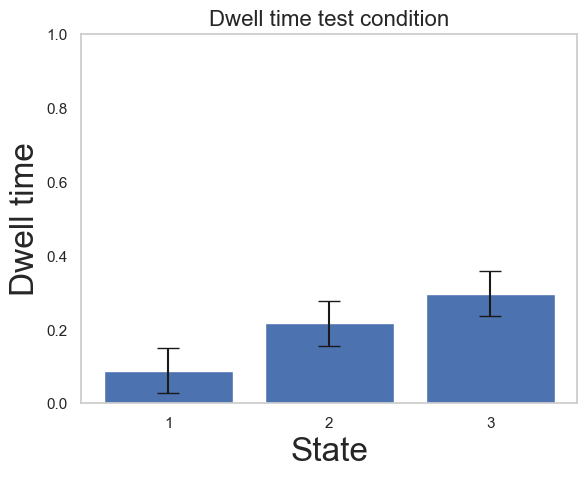

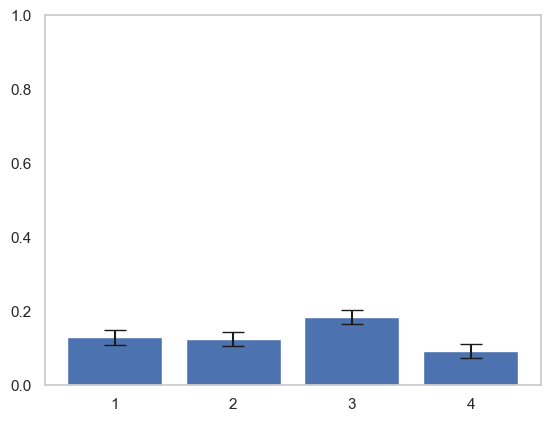

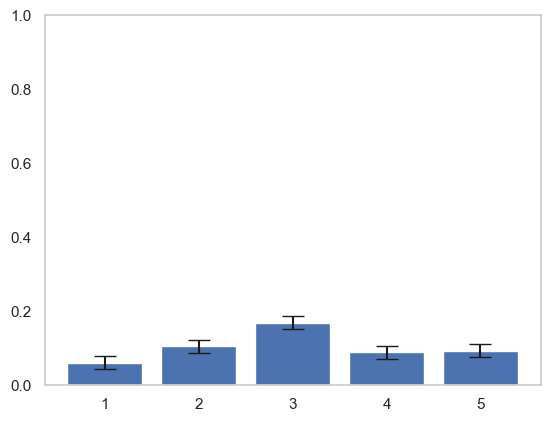

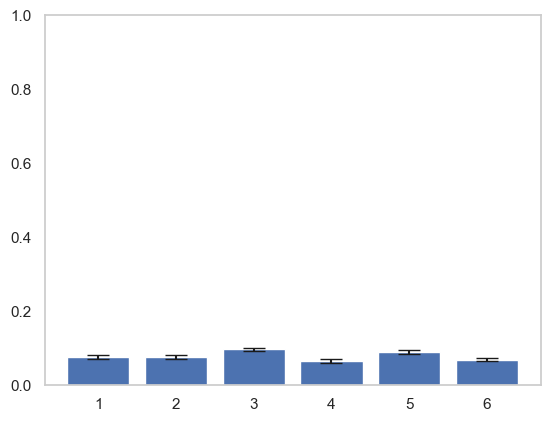

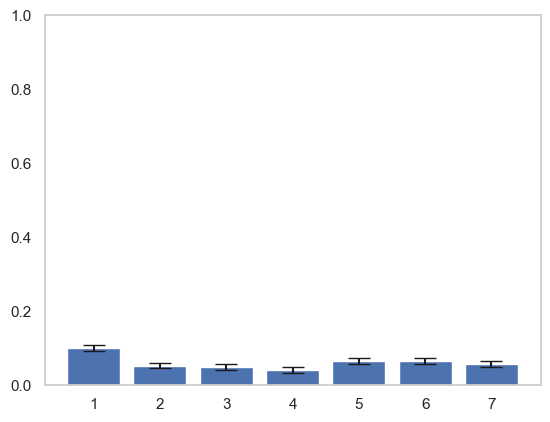

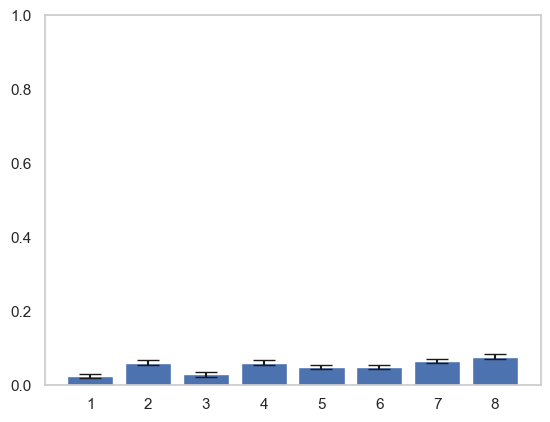

In [41]:
plot_dwell(dwell_time(labels_k3,conditions,3),labels_k3)
plot_dwell(dwell_time(labels_k4,conditions,4),labels_k4)
plot_dwell(dwell_time(labels_k5,conditions,5),labels_k5)
plot_dwell(dwell_time(labels_k6,conditions,6),labels_k6)
plot_dwell(dwell_time(labels_k7,conditions,7),labels_k7)
plot_dwell(dwell_time(labels_k8,conditions,8),labels_k8)

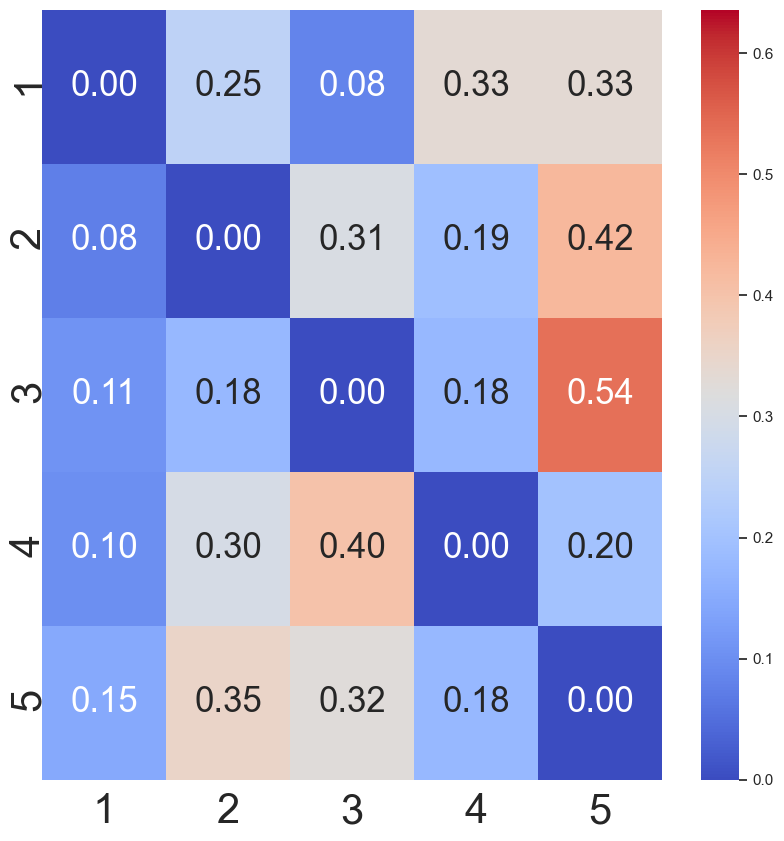

In [44]:
plot_transition_probabilities(labels_k5,['Test'],5)

/var/folders/n1/r_4_0p3n1bxdtgpj3v9ht83w0000gn/T/ipykernel_52145/2101126014.py:102: RuntimeWarning: invalid value encountered in true_divide


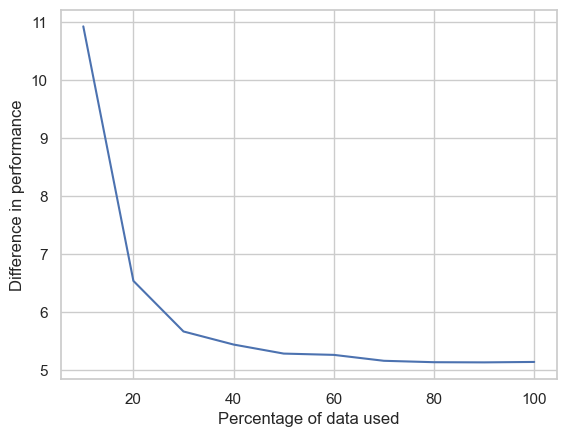

array([[10.93100336],
       [ 6.53831597],
       [ 5.665     ],
       [ 5.4394    ],
       [ 5.2834    ],
       [ 5.2612    ],
       [ 5.159     ],
       [ 5.1346    ],
       [ 5.1318    ],
       [ 5.1392    ]])

In [52]:
# We don't get such drastic difference with real data but on this simulated data we do, so that's that
probability_bootstraping(labels_k5)

## Run the next cell but don't pay attention to it
### It is needed to store the 'bplot2' variable
### Which will be used to have boxplots slightly transparent allowing to better see the datapoints

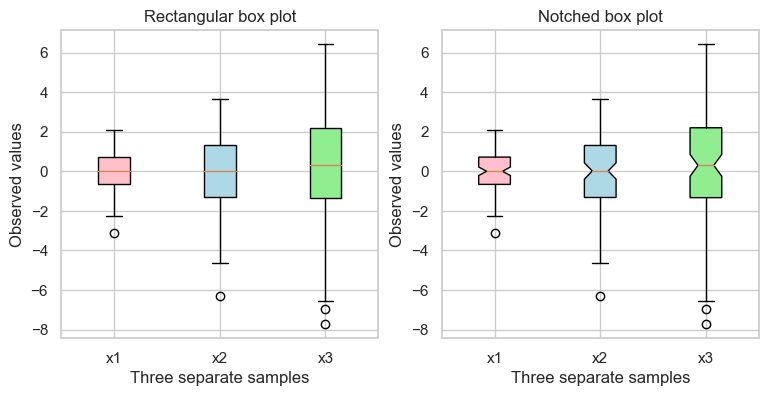

In [45]:
# Random test data
np.random.seed(19680801)
all_data = [np.random.normal(0, std, size=100) for std in range(1, 4)]
labels = ['x1', 'x2', 'x3']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Rectangular box plot')

# notch shape box plot
bplot2 = ax2.boxplot(all_data,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Three separate samples')
    ax.set_ylabel('Observed values')

plt.show()

In [46]:
colors = ['blue']

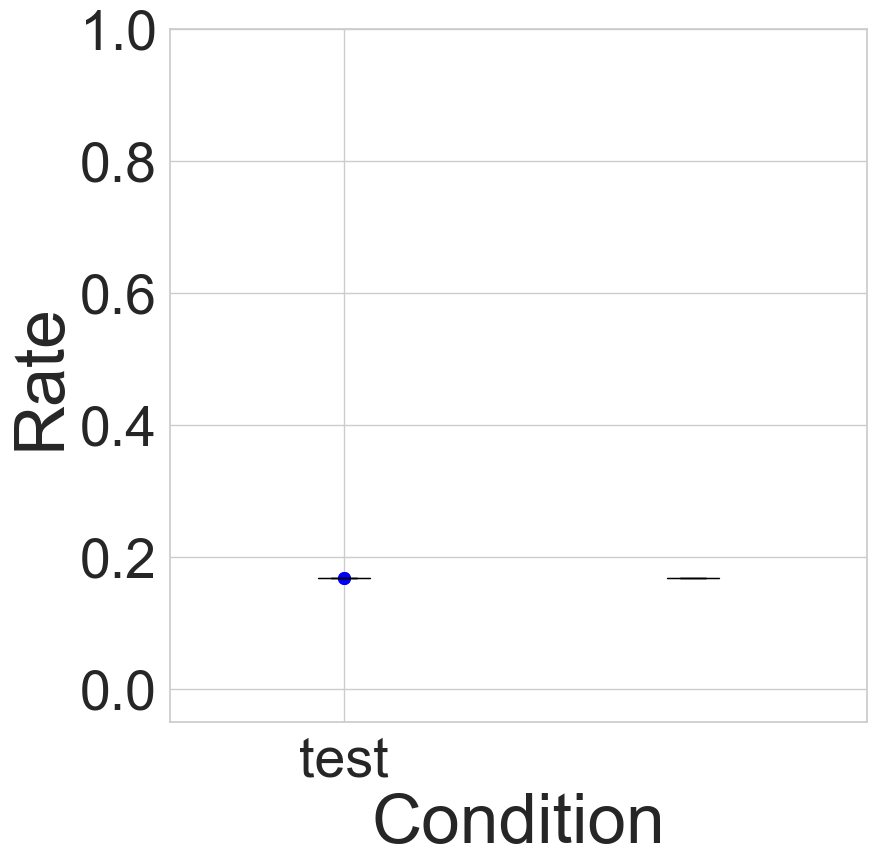

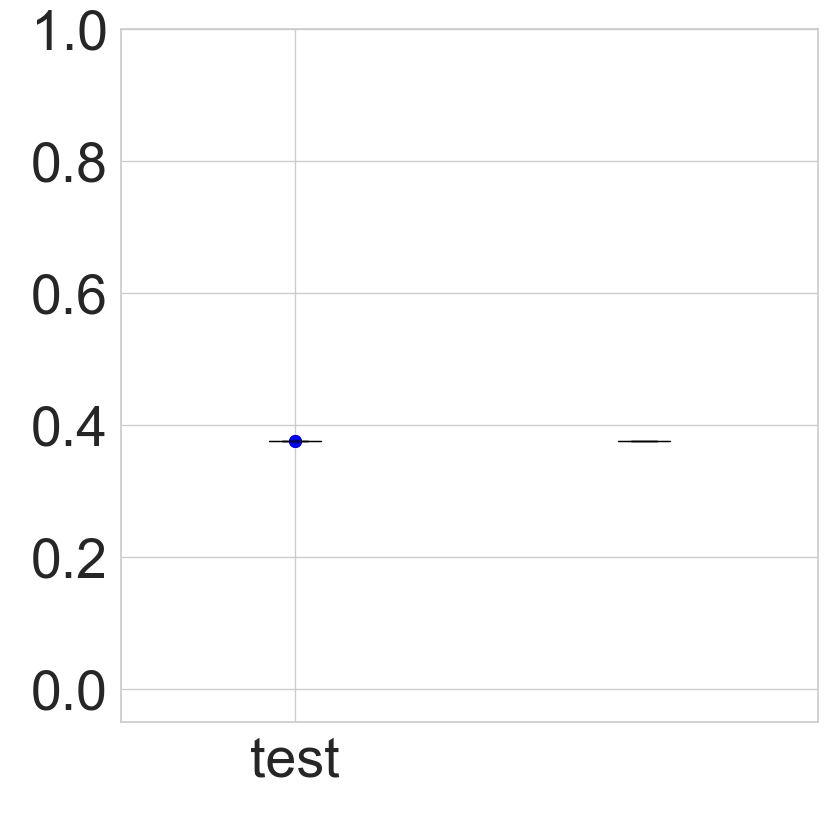

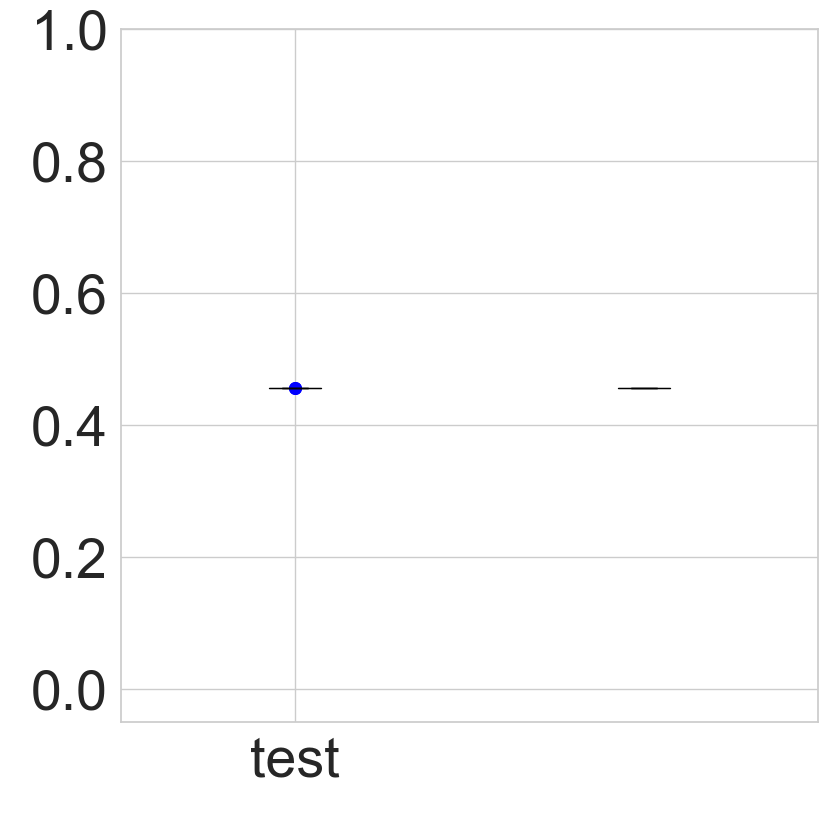

In [47]:
'''
Given the 'optimal' k, here 3, we plot the centroids' presence rate for each condition 
Where we use twice the same data to make the code run and show that one gets a similar figure as in the paper
'''

dist = np.empty((np.sum(num_subj_per_cond),3))
for i in range(np.sum(num_subj_per_cond)):
    dist[i:,] = distribution_pattern_occupation(labels_k3[i*Time_per_rec:(i+1)*Time_per_rec],3,conditions,False)

# rectangular box plot
for i in range(3):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
    bplot1 = ax1.boxplot((dist[:,i],dist[:,i]),
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     boxprops=dict(alpha=.3))  # will be used to label x-ticks
    plt.scatter(np.ones(len(dist[:,i]))*1,dist[:,i],color=colors[0],s=70)
    plt.scatter(np.ones(len(dist[:,i]))*1,dist[:,i],color=colors[0],s=70)
    if i ==0:
        ax1.set_xlabel('Condition', fontsize=50)
        ax1.set_ylabel('Rate', fontsize=50)
    else:
        ax1.set_xlabel([], color='w')
        ax1.set_ylabel([], color='w')
    ax1.set_xticks(np.arange(1,num_cond+1,1),conditions,fontsize=40)
    plt.yticks(fontsize=40)
    plt.ylim((-0.05,1))
    
    # fill with colors
    #colors = ['blue', 'orange', 'green']
    for bplot in (bplot1, bplot2):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
    for median in bplot1['medians']:
        median.set_color('black')
    plt.show()
    plt.close()

In [48]:
pairs_conditions = [('test', 'test')]

/Applications/MNE-Python/.mne-python/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


test v.s. test: t-test paired samples with Bonferroni correction, P_val=nan stat=nan


/Applications/MNE-Python/.mne-python/lib/python3.10/site-packages/statsmodels/stats/anova.py:591: RuntimeWarning: invalid value encountered in double_scalars
/Applications/MNE-Python/.mne-python/lib/python3.10/site-packages/statsmodels/stats/anova.py:594: RuntimeWarning: invalid value encountered in double_scalars


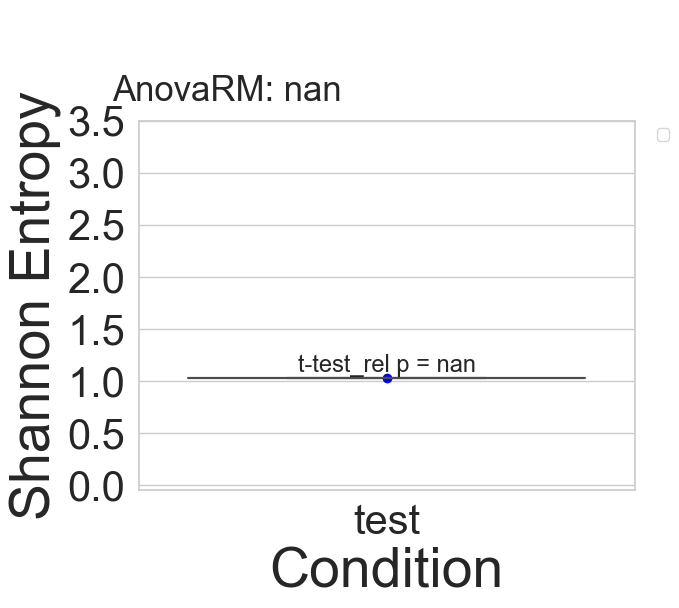

In [49]:
ES_k3 = EntropyShannon(labels_k3,conditions,3)

In [60]:
'''
We want to test if the transitions probability are not biased by the statistics of the data
More presence of the state 1 and 2 should lead to more transitions between 1 and 2 (or vice-versa)
We hence perform a bootstrap test where we will shuffle the labels and compute the transitions probability
This will break the temporal dependencies
We will do this 10000 times and compare the transitions probability of the original data to the distribution of the transitions probability of the shuffled data
If the transitions probability of the original data is in the 95% confidence interval of the distribution of the transitions probability of the shuffled data,
Then we can say that the transitions probability are not biased by the statistics of the data
'''

def bootstrap_test(labels,k):
    TP = np.empty((num_cond,k,k))
    TP_shuffled = np.zeros((num_cond,10000,k,k))
    for i in range(num_cond):
        labels_ = labels[i*Time_per_cond:(i+1)*Time_per_cond]
        TP[i] = probability_only_transitions(labels_,k)
        for j in range(10000):
            np.random.shuffle(labels_)
            TP_shuffled[i,j] = probability_only_transitions(labels_,k)
    return TP,TP_shuffled

def test_bootstrap(TP,TP_shuffled):
    # This code effectively tests work for 1 condition, 2 if you remove the # on the last if loops
    # For comparaison between more than 2 conditions extra if statements are needed
    # Also the percentile can be changed, here we used 95% confidence interval, one can use 99% or 90% as we did for our real data.
    k = TP.shape[1]
    for i in range(k):
        for j in range(k):
            if i!=j:
                if TP[0,i,j] > np.percentile(TP_shuffled[0,:,i,j],95) or TP[0,i,j] < np.percentile(TP_shuffled[0,:,i,j],5):
                    print('Transition from '+str(i+1)+' to '+str(j+1)+' in Awake condition is not due to the statistics of the data')
                #if TP[1,i,j] > np.percentile(TP_shuffled[1,:,i,j],95) or TP[1,i,j] < np.percentile(TP_shuffled[1,:,i,j],5):
                #    print('Transition from '+str(i+1)+' to '+str(j+1)+' in N3 condition is not due to the statistics of the data') 
    return None

In [58]:
TP,TP_shuffled = bootstrap_test(labels_k3,3)

In [61]:
test_bootstrap(TP,TP_shuffled)